<a href="https://colab.research.google.com/github/tmelo-uea/opinion-mining/blob/master/LDA_COVID_AULA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


## Topic Search Model based on Latent Dirichlet Allocation (LDA)

### What's Topic Modeling ?

Topic modelling can be described as a method for finding a group of words (i.e. a topic) from a collection of documents (a "corpus") that best represents the information in the collection. Automatically extracting context from large corpuses of data and dividing them into topics for further drill down is a major application of Natural Language Processing.

### What's a Topic ?

A topic is a repeating pattern of co-occuring terms in a corpus.

### What is Latent Dirichlet Allocation (LDA)?

- LDA assumes documents are produced from a mixture of topics.
- Those topics then generate words based on a probability distribution (LDA is a statistical generative model).
- Given a dataset of documents, LDA backtracks and tries to figure out what topics would create those documents in the first place.

Fonte: [https://capsule8.com](https://capsule8.com)

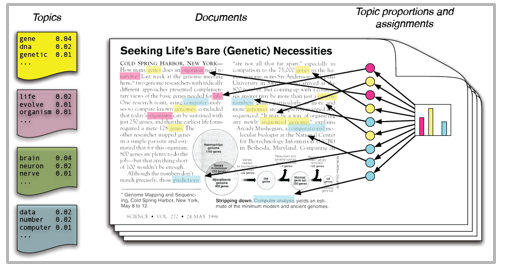

### Import necessary libraries

In [ ]:
!pip install pyLDAvis
!pip install nltk

In [ ]:
#Import libraries
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy
import spacy.cli
spacy.cli.download("pt_core_news_sm")

# Plotting tools
import pyLDAvis
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

pd.set_option('display.max_rows', 5000)
pd.set_option('display.max_columns', 5000)
pd.set_option('display.width', 1000)

from IPython.display import display, HTML
display(HTML(data="""
<style>
   div#notebook-container    { width: 95%; }
   div#menubar-container     { width: 95%; }
   div#maintoolbar-container { width: 99%; }
</style>
"""))

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

✔ Download and installation successful
You can now load the model via spacy.load('pt_core_news_sm')


### Upload the pcap file exported as csv



In [ ]:
from google.colab import files
uploaded = files.upload()

Saving dataset-perguntas-marco.dat to dataset-perguntas-marco (2).dat


In [ ]:
import random
import codecs
data = []
arquivos = ['dataset-perguntas-marco.dat']
for arquivo in arquivos:
  with codecs.open(arquivo) as infile:
    for line in infile:
      data.append(line.strip())

print (len(data))
random.shuffle(data)
data = data[:1000]
print (len(data),type(data))
print (data[:10])

98040
1000 <class 'list'>
['Relatos de pessoas de quarentena na rua, porque “quem controla isso?!”.', 'Funcionando no momento em meio essa pandemia mundial?', 'Será @veramagalhaes?', 'Medo de ninguém ir na minha festa por causa do corona vírus, e agora?????????', '@antoniocostapm estamos à espera de quê para Lockdown Total?', 'E sabia que os pangolins são dos animais mais caçados em #Angola, devido à sua carne e escamas, usados na medicina tradicional asiática, sendo os seus efeitos de cura um mito!?', 'Estou vendo criticas contra a posição do Presidente quanto ao isolamento social, mas me digam: porque vocês não estão em casa?', 'Não gostou,  @EmbaixadaChina  ?', 'Se ainda não há hospital de campanha em Curitiba, será que um destes hospitais poderia ser exclusivo para atendimento da COVID19?', 'no último exame que fiz, há um mês, eu vi que tava com deficiência de vitamina D. O que a falta de vitamina D facilita?']


## NLP preprocessing data

In [ ]:
# NLTK Stop words
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = stopwords.words('portuguese')
l = ['tá', 'ta', 'pq', 'há', 'ha', 'vcs', 'então', 'entao', 'vc', 'ok', 'sc', 'já', 'ja', 'são', 'sao', 'oi', 'com', 'do', 'eh', 'mear', 'sim', 'estão', 'estao']
stop_words.extend(l)

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
print (len(data_words))
print (data_words[:5])

1000
[['relatos', 'de', 'pessoas', 'de', 'quarentena', 'na', 'rua', 'porque', 'quem', 'controla', 'isso'], ['funcionando', 'no', 'momento', 'em', 'meio', 'essa', 'pandemia', 'mundial'], ['sera', 'veramagalhaes'], ['medo', 'de', 'ninguem', 'ir', 'na', 'minha', 'festa', 'por', 'causa', 'do', 'corona', 'virus', 'agora'], ['antoniocostapm', 'estamos', 'espera', 'de', 'que', 'para', 'lockdown', 'total']]


In [ ]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[3]]])

['medo', 'de', 'ninguem', 'ir', 'na', 'minha', 'festa', 'por', 'causa', 'do', 'corona_virus', 'agora']


/usr/local/lib/python3.7/dist-packages/gensim/models/phrases.py:598: UserWarning:

For a faster implementation, use the gensim.models.phrases.Phraser class



In [ ]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent))
#        texts_out.append([token for token in doc if token.pos_ in allowed_postags]) #DESCONSIDERANDO LEMMA
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags]) 
    return texts_out

In [ ]:
#spacy.cli.download("pt_core_news_sm")
#!python -m spacy download pt_core_news_sm
#nlp = spacy.load("pt_core_news_sm", disable=['parser','ner'])
#doc = nlp("A bateria é muito fantástica.")
#print([(w.text, w.pos_) for w in doc])

In [ ]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
#python3 -m spacy download en
#!python -m spacy download pt_core_news_sm
#nlp = spacy.load("pt_core_news_sm")
##nlp = spacy.load('en', disable=['parser', 'ner'])
nlp = spacy.load("pt_core_news_sm", disable=['parser','ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'VERB'])
#data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
#data_lemmatized = data_words_bigrams
print(data_lemmatized[:10])
#print(data_words_bigrams)

[['pessoa', 'ruir', 'controlar'], ['funcionar', 'momento', 'pandemia'], ['sera'], ['medo', 'ninguem', 'ir', 'festa', 'causar', 'corona_virus'], ['esperar'], ['saber', 'pangolins', 'animar', 'cacados', 'angola', 'carnar', 'usar', 'medicinar', 'ser', 'efeito', 'curar', 'mito'], ['ver', 'criticar', 'posicao', 'presidente', 'dizer', 'voces'], ['gostar'], ['sera', 'ser', 'atendimento'], ['ultimar', 'tava', 'deficiencia']]


In [ ]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:10])

[[(0, 1), (1, 1), (2, 1)], [(3, 1), (4, 1), (5, 1)], [(6, 1)], [(7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1)], [(13, 1)], [(14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1)], [(26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1)], [(32, 1)], [(6, 1), (24, 1), (33, 1)], [(34, 1), (35, 1), (36, 1)]]


In [ ]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:5]]

[[('controlar', 1), ('pessoa', 1), ('ruir', 1)],
 [('funcionar', 1), ('momento', 1), ('pandemia', 1)],
 [('sera', 1)],
 [('causar', 1),
  ('corona_virus', 1),
  ('festa', 1),
  ('ir', 1),
  ('medo', 1),
  ('ninguem', 1)],
 [('esperar', 1)]]

In [ ]:
len(corpus)

1000

## Run multiple LDA models with different *N* topics to find the best *N-topic model*


### Compute coherence score for mulitple 'N' number of topics to find the optimum number

In [ ]:
%%time
def compute_coherence_values(dictionary, corpus, texts, limit, start=1, step=2):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values


CPU times: user 8 µs, sys: 0 ns, total: 8 µs
Wall time: 12.9 µs


In [ ]:
%%time
# Can take a long time to run.
#model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=1, limit=30, step=1)
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=1, limit=40, step=2)

CPU times: user 59.9 s, sys: 1.71 s, total: 1min 1s
Wall time: 59 s


### Plot the coherence scores for different N topics
#### Select optimum N

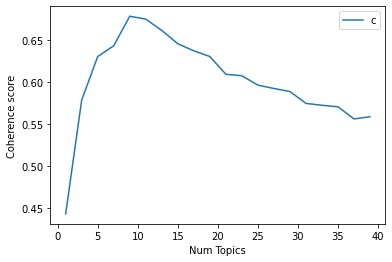

range(1, 40, 2)
[0.44266336949359986, 0.5782199014364252, 0.6300165856507125, 0.642853722084143, 0.6780316194543315, 0.6745751391634823, 0.6611116605812476, 0.6453074392145323, 0.6368490949664847, 0.6300547028697977, 0.6089574669553522, 0.6071552161438261, 0.5960185725723267, 0.5920008711315347, 0.5883875233269934, 0.5742760824227193, 0.5720042174108332, 0.570205327544507, 0.5557626683045918, 0.5583546830095129]


In [ ]:
## Plot the coherence scores for different N topics
### Select optimum N

# Show graph
#limit=30; start=1; step=1;
limit=40; start=1; step=2;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()
print (x)
print (coherence_values)

In [ ]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 1  has Coherence Value of 0.4427
Num Topics = 3  has Coherence Value of 0.5782
Num Topics = 5  has Coherence Value of 0.63
Num Topics = 7  has Coherence Value of 0.6429
Num Topics = 9  has Coherence Value of 0.678
Num Topics = 11  has Coherence Value of 0.6746
Num Topics = 13  has Coherence Value of 0.6611
Num Topics = 15  has Coherence Value of 0.6453
Num Topics = 17  has Coherence Value of 0.6368
Num Topics = 19  has Coherence Value of 0.6301
Num Topics = 21  has Coherence Value of 0.609
Num Topics = 23  has Coherence Value of 0.6072
Num Topics = 25  has Coherence Value of 0.596
Num Topics = 27  has Coherence Value of 0.592
Num Topics = 29  has Coherence Value of 0.5884
Num Topics = 31  has Coherence Value of 0.5743
Num Topics = 33  has Coherence Value of 0.572
Num Topics = 35  has Coherence Value of 0.5702
Num Topics = 37  has Coherence Value of 0.5558
Num Topics = 39  has Coherence Value of 0.5584


### Model selection: Let's see how the model with 12 topics looks like

- Since the coherence score 0.46, looks like the rough  average among the coherence scores of models tested so far. (You can play around with different models to see how the topics vary)
- The topics would differ as we add more data, this is for a small sample of the original dataset)


In [ ]:
max_index = max(enumerate(coherence_values),key=lambda x: x[1])[0]
print (max_index)

4


In [ ]:
max_index = max(enumerate(coherence_values),key=lambda x: x[1])[0]

# Select the model and print the topics
optimal_model = model_list[max_index]
#optimal_model = model_list[9]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=20))

[(0,
  '0.048*"alguem" + 0.034*"caso" + 0.033*"dar" + 0.027*"pensar" + '
  '0.027*"esperar" + 0.024*"parar" + 0.021*"tratar" + 0.019*"falto" + '
  '0.017*"governar" + 0.016*"lockdown" + 0.016*"medir" + 0.013*"viver" + '
  '0.013*"mandar" + 0.013*"colocar" + 0.012*"tava" + 0.011*"todo_mundo" + '
  '0.011*"ministrar" + 0.010*"ler" + 0.010*"centena" + 0.010*"hospital"'),
 (1,
  '0.164*"fazer" + 0.128*"sera" + 0.042*"pandemia" + 0.027*"perguntar" + '
  '0.025*"existir" + 0.018*"presidente" + 0.014*"tratamento" + '
  '0.013*"infectar" + 0.012*"tambem" + 0.011*"escola" + 0.010*"voltar" + '
  '0.009*"poder" + 0.008*"pera" + 0.008*"modelar" + 0.008*"doacoes" + '
  '0.008*"quebrar" + 0.007*"responder" + 0.006*"pontar" + 0.006*"lock" + '
  '0.006*"estudar"'),
 (2,
  '0.044*"dia" + 0.034*"tomar" + 0.028*"ser" + 0.025*"combater" + 0.025*"pai" '
  '+ 0.024*"ajudar" + 0.021*"entender" + 0.020*"significar" + '
  '0.016*"sobreviver" + 0.014*"cade" + 0.014*"precisar" + 0.013*"chamar" + '
  '0.011*"olha

### Dominant topic in each document and topic weight

Each document (here, each data point) can be composed of multiple topics. But generally there one dominant topic, let's extract that.

In [ ]:
%%time
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

CPU times: user 3.36 s, sys: 35 ms, total: 3.39 s
Wall time: 3.38 s


### Most representative sentence for each topic

In [ ]:
# Display setting to show more characters in column
pd.options.display.max_colwidth = 100

sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show
sent_topics_sorteddf_mallet

AttributeError: ignored

   Topic_Num  Topic_Perc_Contrib                                                                                     Keywords                                                                                  Representative Text
0        0.0              0.8187                 alguem, caso, dar, pensar, esperar, parar, tratar, falto, governar, lockdown  Mas não nos esqueçamos de que podemos interagir com nossos amigos e familiares por meio das inúm...
1        1.0              0.8616  fazer, sera, pandemia, perguntar, existir, presidente, tratamento, infectar, tambem, escola  #cnnbrasil #coronavirusbrasil #ministeriodasaude Se demorarmos para fazer o relaxamento do dista...
2        2.0              0.8217               dia, tomar, ser, combater, pai, ajudar, entender, significar, sobreviver, cade                 A própria OMS tá precisando rever seu discurso, qual seria a orientação norteadora?.
3        3.0              0.8225       pandemia, coronavirus, entrar, falir, verdade, contar

### Word cloud for Top words in Each topic

Each topic is represent as a word cloud made up of the keywords with the size of the word in the plot, proportional to its weightage.

IndexError: ignored

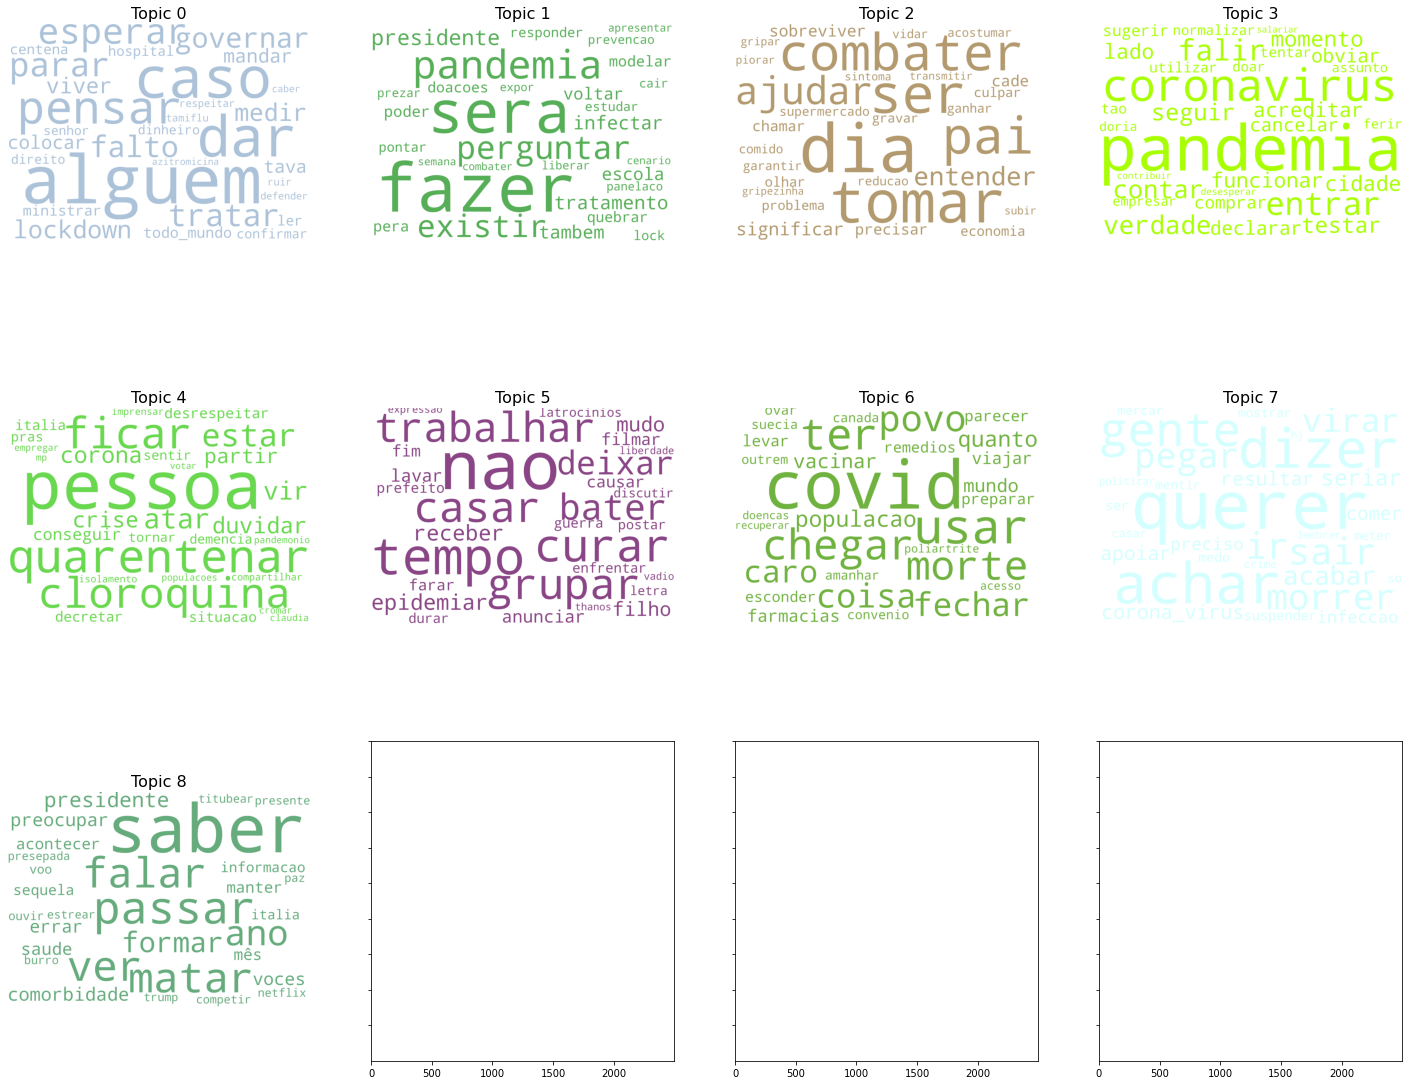

In [ ]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'
cols = [color for name, color in mcolors.XKCD_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'


cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=30,
                  colormap='paired',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = optimal_model.show_topics(formatted=False, num_topics=30, num_words=30)
topics.sort(key=lambda tup: tup[0])

fig, axes = plt.subplots(3, 4, figsize=(25,20), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=550)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

In [ ]:
topics

### TSNE Clustering

TSNE (t-Distributed Stochastic Neighbor Embedding) is an amazing technique of dimensionatily reduction that can be used for visualizing high-dimensional datasets. 

Here we reduce the raw data to 2 dimensions and plot it by different topics. The topic segregation should be very interesting - meaning if the topics are well-segregated, we will see clearly distiguishable clusters (Hover over it to find out what is the data point)

In [ ]:
%%time
# Get topic weights and dominant topics ------------
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook

# Get topic weights
topic_weights = []
for i, row_list in enumerate(optimal_model[corpus]):
    topic_weights.append([w for i, w in row_list[0]])

# Array of topic weights    
arr = pd.DataFrame(topic_weights).fillna(0).values

# # Keep the well separated points (optional)
# arr = arr[np.amax(arr, axis=1) > 0.35]

# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)

# tSNE Dimension Reduction
tsne_model = TSNE(n_components=2, verbose=0, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)

In [ ]:
df_dominant_topic

In [ ]:
import plotly.express as px
import plotly.graph_objects as go


tsne_lda_df = pd.DataFrame(tsne_lda)
tsne_lda_df.columns = ['col1', 'col2']
tsne_lda_df['topic'] = df_dominant_topic['Dominant_Topic']
#raw_data = raw_data.reset_index(drop=True)
#tsne_lda_df['label'] = raw_data['label']
#tsne_lda_df['Info'] = raw_data['Info']
tsne_lda_df['Info'] = data

tsne_lda_df['topic'] = tsne_lda_df['topic'].astype('object')

plt.set_cmap('tab20')
fig = px.scatter(tsne_lda_df, x='col1', y='col2', hover_name='Info',
              color='topic',
              #facet_col='topic', 
                color_discrete_sequence=px.colors.carto.Bold)
#                   color_discrete_map={"0": "blue", "1": "green", "2":"red", "3":"yellow", "4":"magenta", "5":"cyan",
#                                      "6":"deepskyblue", "7":"lightcoral", "8":"darkorange", "9":"aquamarine",
#                                      "10":"peru", "11":"darkkhaki"})

fig.update_layout(
    title=go.layout.Title(
        text="TSNE representation of tcpdump data segregated by topics",
        xref="paper",
        x=0
    ),
    xaxis=go.layout.XAxis(
        title=go.layout.xaxis.Title(
            text="TSNE Dim 1",
            font=dict(
                family="Courier New, monospace",
                size=18,
                color="#7f7f7f"
            )
        )
    ),
    yaxis=go.layout.YAxis(
        title=go.layout.yaxis.Title(
            text="TSNE Dim 2",
            font=dict(
                family="Courier New, monospace",
                size=18,
                color="#7f7f7f"
            )
        )
    )
)

fig.show()

## Visualizing the topic model

In [ ]:
# Visualize the topics
import pyLDAvis.gensim_models

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(optimal_model, corpus, id2word, sort_topics=False)
vis